In [2]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Permute
from keras.layers import ConvLSTM2D, Conv2D, MaxPooling2D
from keras.layers import MaxPooling1D, Conv1D
from keras.layers import GRU, LSTM, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Flatten, Reshape, Dropout
from keras.utils import to_categorical
from keras.layers import Activation
from keras import regularizers

from UtilNNDL import create_window_data
from UtilNNDL import plot_hist
from UtilNNDL import prepare_data
from UtilNNDL import plot_confusion_matrix
from UtilNNDL import bandpass_cnt
from UtilNNDL import exponential_running_standardize

(287, 22, 1000)
[[ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 ..., 
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]]


In [5]:
#Prepare the data by taking out nans and dividing into test and train
file_path = 'datasets/'
train_data, test_data, train_labels, test_labels = prepare_data(file_path, 
                                                                num_test_samples = 50, 
                                                                verbose= False, 
                                                                return_all=True,
                                                                num_files =1)
print train_data.shape
print train_labels.shape
print test_data.shape
print test_labels.shape

(237, 22, 1000)
(237, 4)
(50, 22, 1000)
(50, 4)


In [6]:
#assist numerical stability
train_data = train_data*(1e6)
test_data = test_data*(1e6)
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2)
print train_data.shape
print test_data.shape
for i,a in enumerate(train_data):
    train_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)
for i,a in enumerate(test_data):
    test_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)    
print train_data.shape
print test_data.shape

(237, 1000, 22)
(50, 1000, 22)
(237, 1000, 22)
(50, 1000, 22)


In [69]:
#Standardize the data
for i,a in enumerate(train_data):
    train_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
for i,a in enumerate(test_data):
    test_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2) 
print train_data.shape
print test_data.shape

NameError: name 'exponential_running_standardize' is not defined

In [14]:
#Augment the data into a bigger set by windowing
train_data_sliced, train_labels_sliced = create_window_data(train_data, train_labels, windows=10)
test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=10)
print train_data_sliced.shape
print train_labels_sliced.shape
print test_data_sliced.shape
print test_labels_sliced.shape 

(287, 22, 1000)
(237, 22, 1000)
(50, 22, 1000)


In [18]:
train_data_sliced, train_labels_sliced = create_window_data(train_data, train_labels, windows=10)
test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=10)
print train_data_sliced.shape
print train_labels_sliced.shape
print test_data_sliced.shape
print test_labels_sliced.shape 

(2370, 22, 512)
(2370, 4)
(500, 22, 512)
(500, 4)


In [19]:
test_data_sliced = test_data_sliced[:500,:]
test_labels_sliced = test_labels_sliced[:500,:]
print test_data_sliced.shape
print test_labels_sliced.shape 

(500, 22, 512)
(500, 4)


In [26]:
traindata2d = train_data_sliced.reshape(train_data_sliced.shape[0], train_data_sliced.shape[2], train_data_sliced.shape[1], 1)
testdata2d = test_data_sliced.reshape(test_data_sliced.shape[0], test_data_sliced.shape[2], test_data_sliced.shape[1], 1)
print traindata2d.shape
print testdata2d.shape

(2370, 512, 22, 1)
(500, 512, 22, 1)


# TESTING


deepconvnet no regularization

In [27]:
num_filters = 10
model = Sequential()
model.add(Conv2D(num_filters, kernel_size=(num_filters,1), activation='relu', data_format='channels_last', input_shape=(data2d.shape[1], data2d.shape[2], data2d.shape[3])))  
model.add(Conv2D(num_filters, kernel_size=(15,num_filters), activation='relu') ) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))

model.add(Conv2D(num_filters*2, kernel_size=(10,num_filters), activation='relu')) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))

model.add(Conv2D(num_filters*4, kernel_size=(10,num_filters*2), activation='relu')) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))

model.add(Conv2D(num_filters*8, kernel_size=(10,num_filters*4), activation='relu')) 
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Reshape((num_filters*8,1)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
#model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
hist = model.fit(traindata2d,train_labels_sliced,epochs=15,validation_split=0.25,batch_size=32)
#model.test_on_batch(test_data, test_labels)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 503, 22, 10)       110       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 489, 13, 10)       15010     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 163, 13, 10)       0         
_________________________________________________________________
permute_16 (Permute)         (None, 163, 10, 13)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 154, 1, 20)        26020     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 51, 1, 20)         0         
_________________________________________________________________
permute_17 (Permute)         (None, 51, 20, 1)         0         
__________

500/500 [==============================] - 1s 1ms/step
Test Score: [10.5003583984375, 0.28000000000000003]


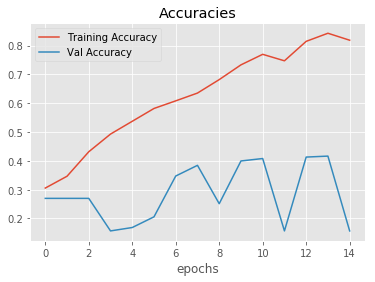

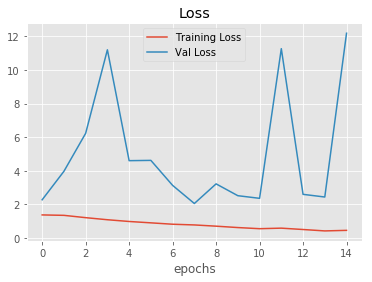

In [30]:
test_score = model.evaluate(testdata2d, test_labels_sliced, batch_size=32)
print "Test Score: {}".format(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')

Trying out:
    * X batchnorm before nonlinearity
    * X regularization
    * dropout 0.5 applied to inputs to conv layers after the first
    * “new tied loss function” for further regularization

In [6]:
num_filters = 10
model = Sequential()
model.add(Conv2D(num_filters, kernel_size=(num_filters,1), activation='relu', data_format='channels_last', input_shape=(data2d.shape[1], data2d.shape[2], data2d.shape[3]), kernel_initializer='glorot_normal', bias_initializer='glorot_normal'))  
model.add(Conv2D(num_filters, kernel_size=(15,num_filters), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal') ) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))
model.add(Dropout(0.5))

model.add(Conv2D(num_filters*2, kernel_size=(10,num_filters), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))
model.add(Dropout(0.5))

model.add(Conv2D(num_filters*4, kernel_size=(10,num_filters*2), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Permute((1,3,2)))
model.add(Dropout(0.5))

model.add(Conv2D(num_filters*8, kernel_size=(10,num_filters*4), activation='relu', kernel_initializer='glorot_normal', bias_initializer='glorot_normal')) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(Reshape((num_filters*8,1)))
model.add(LSTM(32, return_sequences=True))

model.add(Flatten())
model.add(Dense(4, activation='softmax', kernel_initializer='glorot_normal', bias_initializer='glorot_normal'))
model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
hist = model.fit(train_data,train_labels,epochs=25,validation_split=0.25,batch_size=32)
#model.test_on_batch(test_data, test_labels)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 503, 22, 10)       110       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 489, 13, 10)       15010     
_________________________________________________________________
batch_normalization_1 (Batch (None, 489, 13, 10)       40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 163, 13, 10)       0         
_________________________________________________________________
permute_1 (Permute)          (None, 163, 10, 13)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 163, 10, 13)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 154, 1, 20)        26020     
__________

50/50 [==============================] - 0s 2ms/step
Test Score: [1.5261143445968628, 0.46000000834465027]


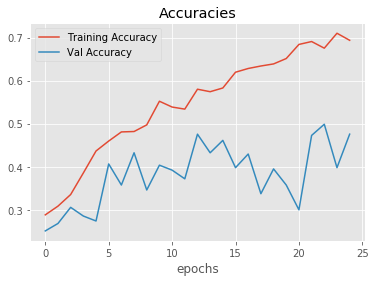

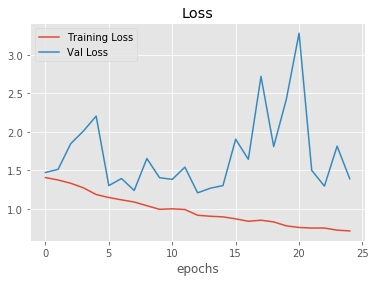

In [7]:
test_score = model.evaluate(test_data, test_labels, batch_size=128)
print "Test Score: {}".format(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')